In [1]:
import torch
from sd_pipeline import StableDiffusion3Pipeline
from sd_processor import JointAttnProcessor2_0
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")

/home/wg25r/miniconda/envs/mochi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s]


In [2]:
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()

In [3]:
prompt = "A cozy dining area bathed in morning light with polished wooden surfaces"
negative_prompt = "there are chair, bench, and stool in the image"
pipe.tokenizer.tokenize(negative_prompt)

['there</w>',
 'are</w>',
 'chair</w>',
 ',</w>',
 'bench</w>',
 ',</w>',
 'and</w>',
 'stool</w>',
 'in</w>',
 'the</w>',
 'image</w>']

In [4]:
for block in pipe.transformer.transformer_blocks:
    block.attn.processor.neg_prompt_len=len(pipe.tokenizer.tokenize(negative_prompt)) + 1

  5%|▍         | 3/64 [00:01<00:29,  2.09it/s]

100%|██████████| 64/64 [00:32<00:00,  1.96it/s]


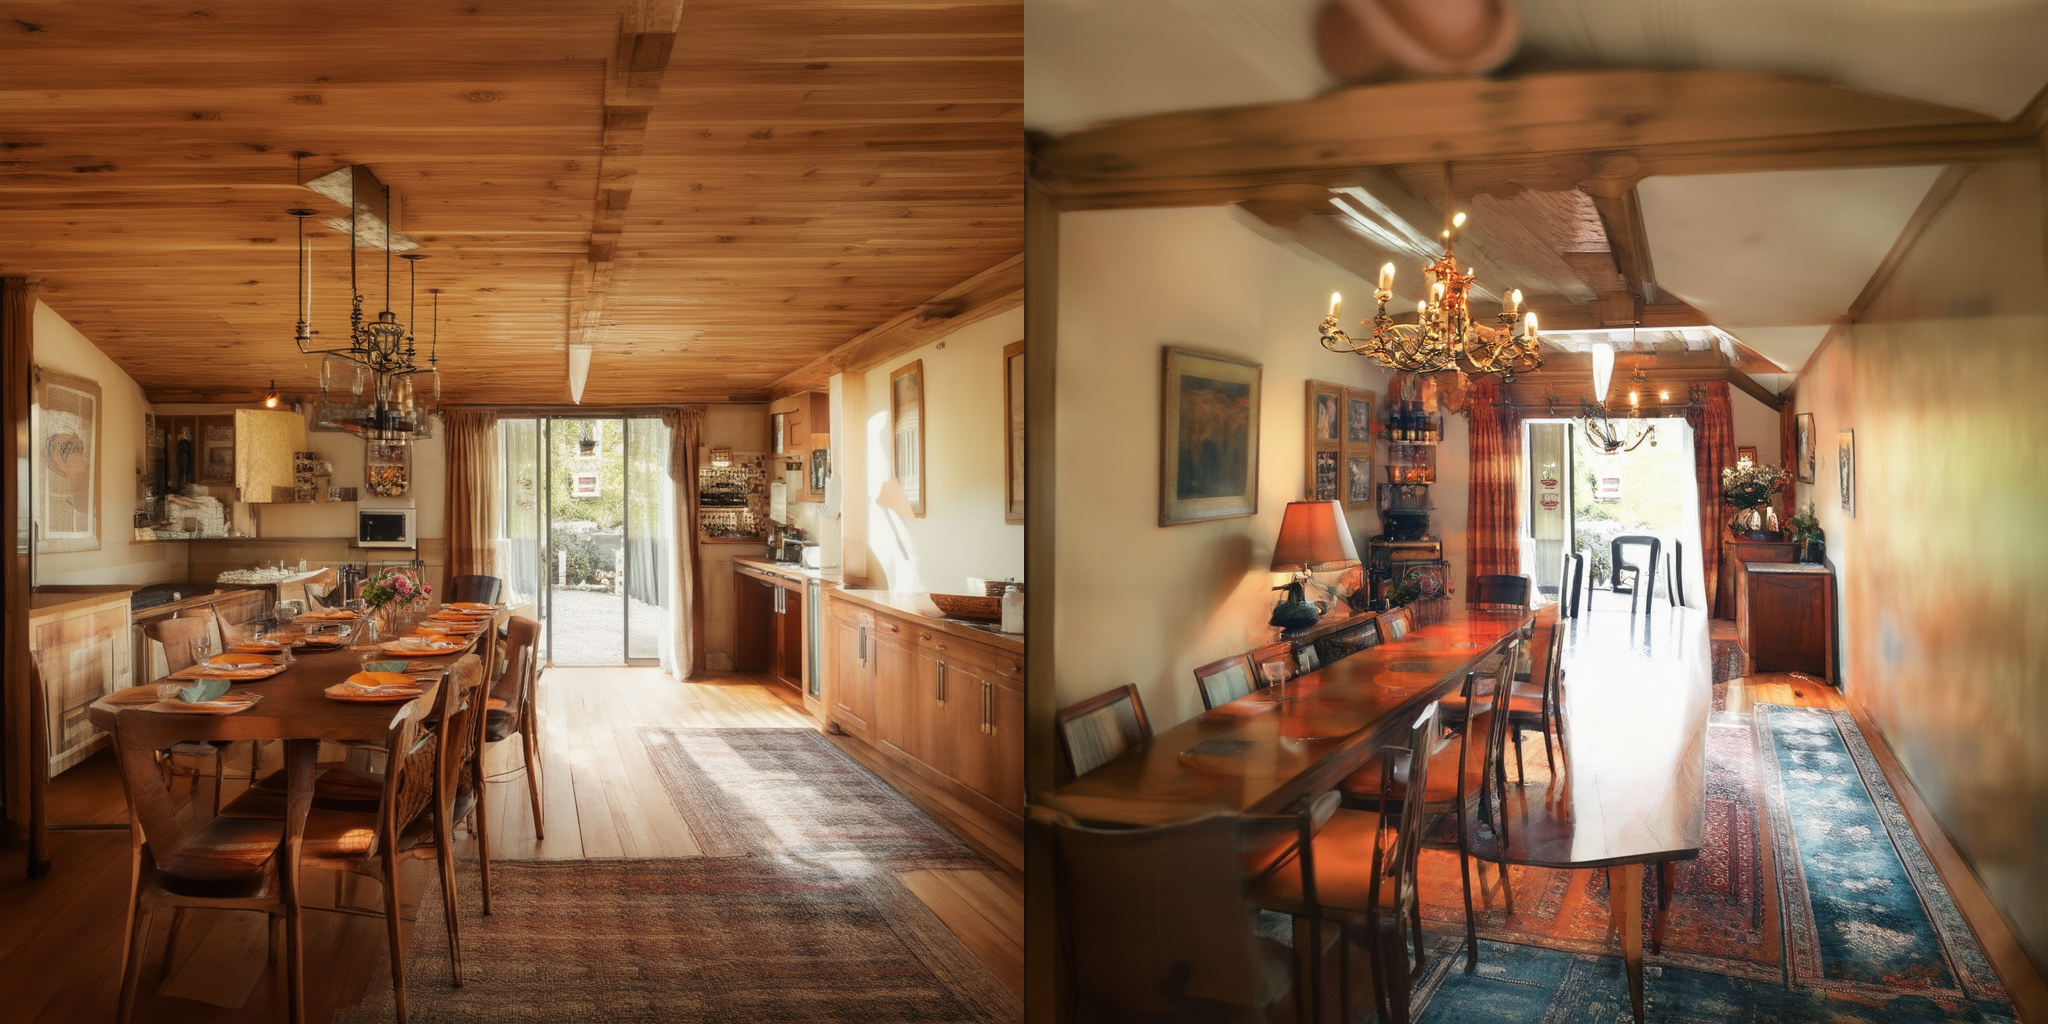

In [8]:
import time
import numpy as np
from PIL import Image
seed = int(time.time())
image1 = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=64,
    avoidance_factor=0,
    guidance_scale=8,
    generator=torch.manual_seed(seed), 
).images[0]  
image2 = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=64,
    avoidance_factor=2, 
    guidance_scale=6,
    generator=torch.manual_seed(seed), 
).images[0] 

# show the images by concatenating them
Image.fromarray(np.concatenate([np.array(image1), np.array(image2)], axis=1))

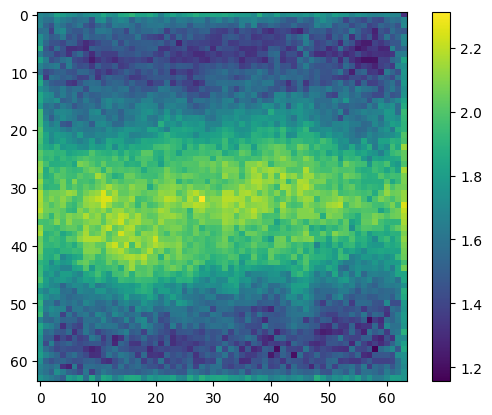

In [6]:
import pylab 
map = torch.stack(pipe.neg_maps)[0].mean((0,1,2,3)).reshape(64, 64).cpu().float().numpy()
pylab.imshow(map) 
pylab.colorbar()

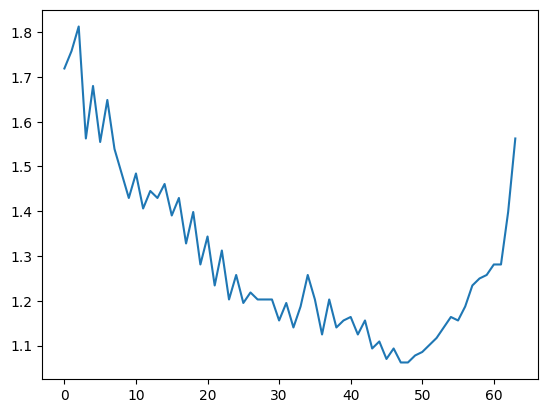

In [7]:
pylab.plot(torch.stack(pipe.neg_maps).mean((1,2,3,4)).abs().mean(-1).cpu().float().numpy())